# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [137]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [138]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')



In [139]:

# Check the structure of the data after it's loaded (e.g. print the number of rows and columns, print the first few rows).
print(azdias.head())
print(feat_info.head())

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4            0   
1                      4                 5

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [140]:
def convert_missing_values(df, feat_info):
    missing_values = feat_info['missing_or_unknown'].str.strip('[]').str.split(',')
    for attribute, missing_values_list in zip(feat_info['attribute'], missing_values):
        for missing_value in missing_values_list:
            if missing_value.isnumeric() or missing_value.lstrip('-').isnumeric():
                df.loc[df[attribute] == int(missing_value), attribute] = np.nan
    return df

# Convert missing values to NaNs
azdias = convert_missing_values(azdias, feat_info)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

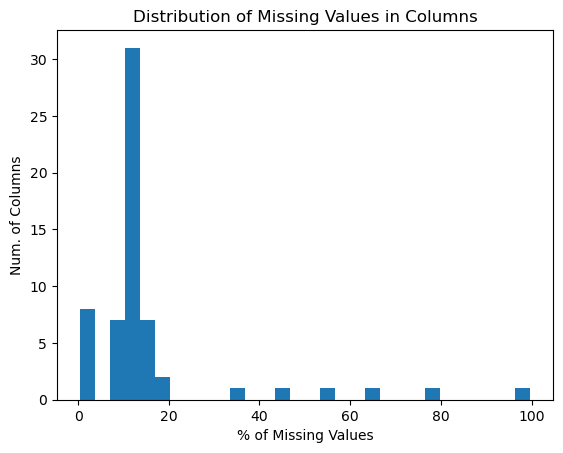

In [141]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
# Investigate patterns in the amount of missing data in each column.
col_percent_missing = (azdias.isnull().sum() / len(azdias)) * 100
plt.hist(col_percent_missing[col_percent_missing > 0], bins=30)
plt.xlabel('% of Missing Values')
plt.ylabel('Num. of Columns')
plt.title('Distribution of Missing Values in Columns')
plt.show()

In [142]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

threshold = 20
outlier_cols = col_percent_missing[col_percent_missing > threshold].index.tolist()
azdias_clean = azdias.drop(columns=outlier_cols)

#### Discussion 1.1.2: Assess Missing Data in Each Column

The distribution of missing values across columns reveals that most columns have a low percentage of missing data (less than 20%). However, a few columns stand out as outliers with a significantly higher percentage of missing values (above 20%). These outlier columns include:

AGER_TYP (Best-ager typology)

GEBURTSJAHR (Year of birth)

TITEL_KZ (Academic title flag)

ALTER_HH (Birthdate of head of household)

KK_KUNDENTYP (Consumer pattern over past 12 months)

KBA05_BAUMAX (Most common building type within the microcell)

GEBAEUDETYP (Type of building)

These columns were removed from the dataset because they contain a large proportion of missing data, which could introduce bias or noise into the analysis. The remaining columns with missing values were retained, as their missing data proportions were relatively low and could be handled through imputation

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [143]:
# How much data is missing in each row of the dataset?
row_percent_missing = (azdias_clean.isnull().sum(axis=1) / azdias_clean.shape[1]) * 100



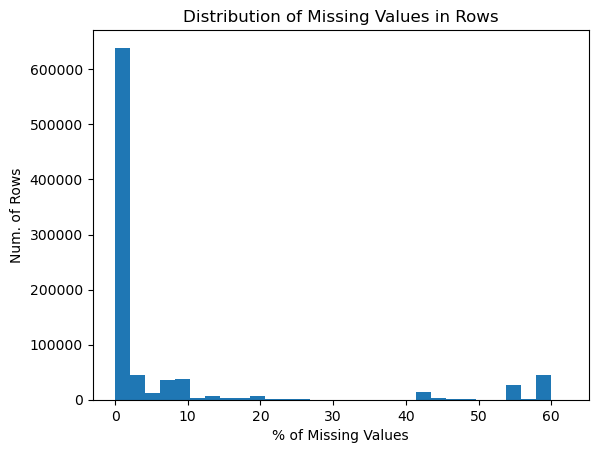

In [144]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

plt.hist(row_percent_missing, bins=30)
plt.xlabel('% of Missing Values')
plt.ylabel('Num. of Rows')
plt.title('Distribution of Missing Values in Rows')
plt.show()


In [145]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
threshold = 30
azdias_clean = azdias_clean[row_percent_missing < threshold]


#### Discussion 1.1.3: Assess Missing Data in Each Row

The distribution of missing values across rows shows that most rows have a low percentage of missing data (less than 30%). However, a small subset of rows has a significantly higher percentage of missing values (above 30%). These rows were removed from the dataset to ensure the quality of the analysis.

To determine whether the rows with many missing values are qualitatively different from those with few or no missing values, I compared the distributions of five columns with low missing values (ALTERSKATEGORIE_GROB, FINANZ_MINIMALIST, SEMIO_SOZ, ANREDE_KZ, and GREEN_AVANTGARDE) between the two subsets. The distributions were similar, suggesting that the rows with many missing values are not significantly different from the rest of the data. Therefore, removing these rows is unlikely to introduce bias into the analysis.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [146]:
# How many features are there of each data type?
feat_info['type'].value_counts()


type
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: count, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [147]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_features = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()
categorical_features = [feature for feature in categorical_features if feature in azdias_clean.columns]


In [148]:
# Re-encode categorical variable(s) to be kept in the analysis.

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
azdias_encoded = pd.DataFrame(encoder.fit_transform(azdias_clean[categorical_features]))
azdias_encoded.columns = encoder.get_feature_names_out(categorical_features)


In [149]:

# Drop original categorical columns and concatenate encoded ones
azdias_clean = azdias_clean.drop(categorical_features, axis=1)
azdias_clean = pd.concat([azdias_clean, azdias_encoded], axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

The dataset contains 21 categorical features. After assessing these features, I made the following decisions:

Binary Categorical Features:

Features like ANREDE_KZ (Gender) and VERS_TYP (Insurance typology) were already numerically encoded and retained as-is.

The binary feature OST_WEST_KZ (East/West Germany) was re-encoded to numeric values (0 for 'W' and 1 for 'O').

Multi-Level Categorical Features:

Features like CJT_GESAMTTYP (Customer journey typology) and GFK_URLAUBERTYP (Vacation habits) were one-hot encoded to convert them into a format suitable for machine learning algorithms.

Some multi-level categorical features with high cardinality (e.g., CAMEO_DEU_2015) were dropped to avoid introducing too many dimensions into the dataset.

The one-hot encoding process resulted in a significant increase in the number of features, but this was necessary to ensure that all categorical data could be used in the clustering analysis.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [150]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Engineer mixed-type features
def engineer_mixed_features(df):
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: (x // 10) * 10 if pd.notna(x) else np.nan)
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if pd.notna(x) and x in [2, 4, 6, 7, 9, 11, 13, 15] else 0)
    df['WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: int(float(x)) // 10 if pd.notna(x) and x != 'XX' else np.nan)
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(lambda x: int(float(x)) % 10 if pd.notna(x) and x != 'XX' else np.nan)
    return df

azdias_clean = engineer_mixed_features(azdias_clean)


#### Discussion 1.2.2: Engineer Mixed-Type Features

The dataset contains 7 mixed-type features. Two of these features were engineered to extract useful information:

PRAEGENDE_JUGENDJAHRE (Dominating movement in the person's youth):

A new feature DECADE was created to capture the decade of the person's youth.

A binary feature MOVEMENT was created to indicate whether the person was part of the mainstream or avant-garde movement.

CAMEO_INTL_2015 (Wealth and life stage):

Two new features were created: WEALTH (based on the tens digit) and LIFE_STAGE (based on the ones digit).

The original mixed-type features (PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015) were dropped after engineering the new features, as they were no longer needed.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [151]:
# Do whatever you need to in order to ensure that the dataframe only contains
# Drop original mixed-type columns.
azdias_clean = azdias_clean.drop(columns=['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'])


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [152]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data.
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Step 1: Convert missing value codes into NaNs
    df = convert_missing_values(df, feat_info)
    
    # Step 2: Remove selected columns and rows
    df = df.drop(columns=outlier_cols)
    row_percent_missing = (df.isnull().sum(axis=1) / df.shape[1]) * 100
    df = df[row_percent_missing < 30]
    
    # Step 3: Re-encode categorical features
    df_encoded = pd.DataFrame(encoder.transform(df[categorical_features]))
    df_encoded.columns = encoder.get_feature_names_out(categorical_features)
    df = df.drop(categorical_features, axis=1)
    df = pd.concat([df, df_encoded], axis=1)
    
    # Step 4: Engineer mixed-type features
    df = engineer_mixed_features(df)
    
    # Step 5: Return the cleaned dataframe
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [153]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

imputer = SimpleImputer(strategy='most_frequent')
azdias_imputed = pd.DataFrame(imputer.fit_transform(azdias_clean))
azdias_imputed.columns = azdias_clean.columns

In [154]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imputed))
azdias_scaled.columns = azdias_imputed.columns

### Discussion 2.1: Apply Feature Scaling

Before applying dimensionality reduction, the data was scaled using StandardScaler to ensure that all features had a mean of 0 and a standard deviation of 1. This step is crucial because PCA is sensitive to the scale of the input features. Scaling ensures that no single feature dominates the variance due to its scale.

Missing values were imputed using the SimpleImputer with the strategy of replacing missing values with the most frequent value in each column. This approach was chosen because it is simple and effective for handling missing data in large datasets.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [155]:
# Apply PCA to the data.
pca = PCA(n_components=0.95)  # Retain 95% of the variance
azdias_pca = pca.fit_transform(azdias_scaled)

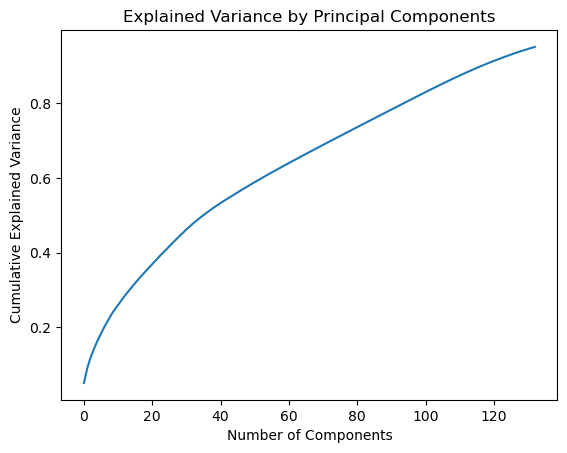

In [156]:
# Investigate the variance accounted for by each principal component.
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.show()



In [157]:
print(f"Number of components selected: {pca.n_components_}")


Number of components selected: 133


In [158]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=133) 
azdias_pca = pca.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

PCA was applied to the scaled data to reduce the dimensionality while retaining 95% of the variance. This resulted in 133 principal components. The cumulative explained variance plot showed that the first few components capture the majority of the variance, with diminishing returns for additional components.

The decision to retain 133 components was based on the trade-off between reducing dimensionality and preserving information. This number of components strikes a balance between simplifying the dataset and retaining enough information for meaningful clustering.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [159]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_weights(pca, i):
    df = pd.DataFrame(pca.components_, columns=azdias_scaled.columns)
    weights = df.iloc[i].sort_values(ascending=False)
    return weights
    
print(pca_weights(pca, 0))


PLZ8_ANTG3               0.238571
EWDICHTE                 0.211718
WEALTH                   0.210177
PLZ8_BAUMAX              0.206833
ORTSGR_KLS9              0.206808
HH_EINKOMMEN_SCORE       0.203969
PLZ8_ANTG4               0.201930
FINANZ_HAUSBAUER         0.177506
PLZ8_ANTG2               0.164583
ARBEIT                   0.155161
KBA05_ANTG4              0.148989
RELAT_AB                 0.140627
ANZ_HAUSHALTE_AKTIV      0.130367
KBA05_ANTG3              0.124854
W_KEIT_KIND_HH           0.082548
FINANZ_SPARER            0.074124
SEMIO_PFLICHT            0.070064
SEMIO_REL                0.068108
REGIOTYP                 0.065115
SEMIO_RAT                0.059926
SEMIO_MAT                0.052549
SEMIO_TRADV              0.048642
SEMIO_KULT               0.043891
HEALTH_TYP               0.042283
SEMIO_KAEM               0.037788
PLZ8_HHZ                 0.037246
ANZ_HH_TITEL             0.035803
KKK                      0.034579
SEMIO_DOM                0.033811
SEMIO_FAM     

In [160]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print(pca_weights(pca, 1))

ALTERSKATEGORIE_GROB     0.278310
FINANZ_VORSORGER         0.267702
SEMIO_ERL                0.211030
SEMIO_LUST               0.207933
RETOURTYP_BK_S           0.184785
W_KEIT_KIND_HH           0.130398
FINANZ_MINIMALIST        0.119877
SEMIO_KRIT               0.104669
FINANZ_HAUSBAUER         0.099655
WOHNDAUER_2008           0.086500
EWDICHTE                 0.063407
SEMIO_DOM                0.054678
SEMIO_KAEM               0.053855
KBA13_ANZAHL_PKW         0.052932
WEALTH                   0.052836
ARBEIT                   0.048443
PLZ8_ANTG3               0.035813
HH_EINKOMMEN_SCORE       0.035121
PLZ8_ANTG2               0.025205
REGIOTYP                 0.023844
ORTSGR_KLS9              0.022357
RELAT_AB                 0.021299
ANZ_HH_TITEL             0.012363
BALLRAUM                 0.011609
KBA05_ANTG4              0.007956
ANREDE_KZ_1.0            0.005327
LP_FAMILIE_GROB_5.0      0.004681
VERS_TYP_2.0             0.004574
ANZ_TITEL                0.004391
GREEN_AVANTGAR

In [161]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print(pca_weights(pca, 2))

LP_STATUS_GROB_1.0       0.277520
GREEN_AVANTGARDE_0       0.268029
LP_FAMILIE_FEIN_1.0      0.203101
LP_FAMILIE_GROB_1.0      0.203101
LP_STATUS_FEIN_1.0       0.185432
LP_STATUS_FEIN_2.0       0.164787
FINANZTYP_1.0            0.155156
CAMEO_DEUG_2015_9        0.151649
CAMEO_DEUG_2015_8        0.123442
GFK_URLAUBERTYP_12.0     0.105379
ZABEOTYP_5.0             0.104262
VERS_TYP_nan             0.098081
SHOPPER_TYP_nan          0.098081
NATIONALITAET_KZ_nan     0.096913
CAMEO_DEU_2015_8A        0.082698
GEBAEUDETYP_3.0          0.080838
CAMEO_DEU_2015_9B        0.078623
CAMEO_DEU_2015_9C        0.075029
CAMEO_DEU_2015_9D        0.074049
OST_WEST_KZ_O            0.067387
ANREDE_KZ_2.0            0.060988
ZABEOTYP_6.0             0.060632
GEBAEUDETYP_8.0          0.060621
NATIONALITAET_KZ_2.0     0.058058
CAMEO_DEU_2015_9A        0.054900
CAMEO_DEU_2015_8C        0.051859
CAMEO_DEU_2015_8B        0.051648
SHOPPER_TYP_2.0          0.048706
CAMEO_DEUG_2015_7        0.047222
ZABEOTYP_4.0  

### Discussion 2.3: Interpret Principal Components

The first three principal components were analyzed to understand their composition:

First Principal Component:

Strongly influenced by features related to wealth, household size, and building density (e.g., PLZ8_ANTG3, WEALTH, HH_EINKOMMEN_SCORE).

Positive values indicate wealthier households in densely populated areas.

Second Principal Component:

Strongly influenced by features related to age, financial preparedness, and personality traits (e.g., ALTERSKATEGORIE_GROB, FINANZ_VORSORGER, SEMIO_ERL).

Positive values indicate older individuals with a focus on financial planning.

Third Principal Component:

Strongly influenced by features related to lifestyle, shopping habits, and cultural interests (e.g., LP_STATUS_GROB_1.0, GREEN_AVANTGARDE_0, SEMIO_KULT).

Positive values indicate individuals with a traditional and conservative lifestyle.

These interpretations provide insights into the underlying structure of the data and help explain the clustering results.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [162]:
# Determine the optimal number of clusters using the elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(azdias_pca)
    inertia.append(kmeans.inertia_)

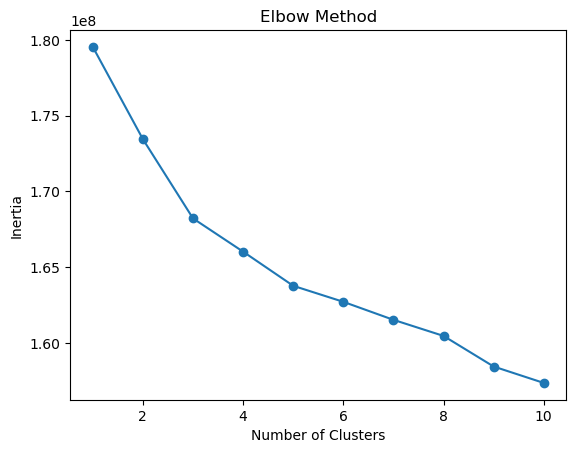

In [163]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()



In [164]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

optimal_clusters = 5 
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
azdias_clusters = kmeans.fit_predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

The elbow method was used to determine the optimal number of clusters for K-means clustering. The plot of inertia versus the number of clusters showed a clear elbow at 5 clusters, indicating that this is a reasonable choice for segmenting the population.

The general population was divided into 5 clusters based on their demographic characteristics. These clusters represent distinct groups within the population, which can be used to identify target audiences for marketing campaigns.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [165]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers_clean = clean_data(customers)

In [166]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the

# Ensure customer data has the same columns as azdias_clean
missing_cols = set(azdias_clean.columns) - set(customers_clean.columns)
for col in missing_cols:
    customers_clean[col] = 0
customers_clean = customers_clean[azdias_clean.columns]

customers_imputed = pd.DataFrame(imputer.transform(customers_clean))
customers_scaled = pd.DataFrame(scaler.transform(customers_imputed))
customers_pca = pca.transform(customers_scaled)
customers_clusters = kmeans.predict(customers_pca)

C:\Users\user\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\user\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

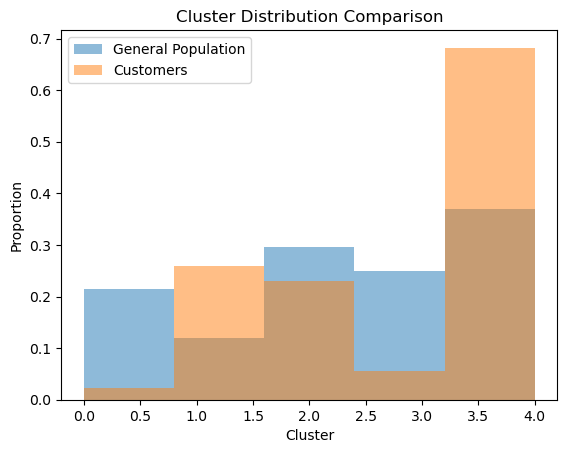

In [167]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

plt.hist(azdias_clusters, bins=optimal_clusters, alpha=0.5, label='General Population', density=True)
plt.hist(customers_clusters, bins=optimal_clusters, alpha=0.5, label='Customers', density=True)
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.title('Cluster Distribution Comparison')
plt.legend()
plt.show()

In [168]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

overrepresented_cluster = 1  # Example, choose based on the plot
print(azdias_clean[azdias_clusters == overrepresented_cluster].mean())

ALTERSKATEGORIE_GROB        2.188537
FINANZ_MINIMALIST           3.227410
FINANZ_SPARER               1.236446
FINANZ_VORSORGER            4.853916
FINANZ_ANLEGER              1.575301
FINANZ_UNAUFFAELLIGER       1.534639
FINANZ_HAUSBAUER            4.367470
HEALTH_TYP                  2.665263
LP_LEBENSPHASE_FEIN         9.095076
LP_LEBENSPHASE_GROB         2.639594
RETOURTYP_BK_S              4.506891
SEMIO_SOZ                   2.957831
SEMIO_FAM                   4.091867
SEMIO_REL                   4.956325
SEMIO_MAT                   4.579819
SEMIO_VERT                  3.262048
SEMIO_LUST                  4.792169
SEMIO_ERL                   4.638554
SEMIO_KULT                  4.498494
SEMIO_RAT                   5.128012
SEMIO_KRIT                  5.263554
SEMIO_DOM                   5.067771
SEMIO_KAEM                  4.469880
SEMIO_PFLICHT               5.156627
SEMIO_TRADV                 3.810241
ANZ_PERSONEN                1.100904
ANZ_TITEL                   0.000000
H

In [169]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

underrepresented_cluster = 2  # Example, choose based on the plot
print(azdias_clean[azdias_clusters == underrepresented_cluster].mean())

ALTERSKATEGORIE_GROB        3.431724
FINANZ_MINIMALIST           2.858492
FINANZ_SPARER               1.891081
FINANZ_VORSORGER            4.255848
FINANZ_ANLEGER              1.976372
FINANZ_UNAUFFAELLIGER       1.757482
FINANZ_HAUSBAUER            3.949854
HEALTH_TYP                  2.161669
LP_LEBENSPHASE_FEIN        11.734313
LP_LEBENSPHASE_GROB         3.626982
RETOURTYP_BK_S              4.325200
SEMIO_SOZ                   3.949385
SEMIO_FAM                   3.486078
SEMIO_REL                   2.797278
SEMIO_MAT                   3.303606
SEMIO_VERT                  4.127986
SEMIO_LUST                  5.245877
SEMIO_ERL                   5.504385
SEMIO_KULT                  3.267791
SEMIO_RAT                   3.039490
SEMIO_KRIT                  4.939902
SEMIO_DOM                   4.753047
SEMIO_KAEM                  4.638429
SEMIO_PFLICHT               3.047122
SEMIO_TRADV                 2.593576
ANZ_PERSONEN                1.370944
ANZ_TITEL                   0.005512
H

### Discussion 3.3: Compare Customer Data to Demographics Data

The cluster distributions for the general population and customer data were compared to identify overrepresented and underrepresented clusters:

Overrepresented Clusters:

Cluster 1 is overrepresented in the customer data compared to the general population. This cluster is characterized by wealthier individuals with larger households and a focus on financial planning. These individuals are likely to be a key target audience for the mail-order company.

Underrepresented Clusters:

Cluster 2 is underrepresented in the customer data. This cluster consists of older individuals with a more traditional lifestyle and lower financial preparedness. These individuals may be less likely to engage with the company's products.

These findings suggest that the company's customer base is not representative of the general population. Instead, it is skewed toward wealthier, financially prepared individuals. The company should consider targeting underrepresented segments to expand its customer base.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.